In [1]:
#Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
torch.cuda.is_available()

False

In [3]:
torch.cuda.device_count()

0

In [4]:
#torch.cuda.current_device()

In [5]:
#torch.cuda.get_device_name(0)

In [6]:
#Set Parameters here
epochs = 300000
batch_size = 1000
train_points = 1000 # 60k total training examples, 10k test examples
test_points = 1000
lr = 0.001
weight_decay = 0.01
initialization_scale = 8.0
#Optmization steps should be train_points/batchsize * epochs 
print(train_points/batch_size * epochs)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


300000.0


In [7]:
print(device)

cpu


In [8]:
#Network Structure
class mnistClassification(nn.Module):
    def __init__(self):
        super(mnistClassification, self).__init__()
        self.flatten = nn.Flatten().to(device)
        self.fc1 = nn.Linear(784, 200).to(device)
        self.fc2 = nn.Linear(200, 200).to(device)
        self.fc3 = nn.Linear(200, 10).to(device)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = mnistClassification().to(device)

with torch.no_grad(): 
    for p in model.parameters(): 
        p.data = initialization_scale * p.data

In [9]:
#Load Data set
train = torchvision.datasets.MNIST(root='mnistdata', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root='mnistdata', train=False, transform=torchvision.transforms.ToTensor(), download=True)
train = torch.utils.data.Subset(train, range(train_points))
test = torch.utils.data.Subset(test, range(test_points))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(test_loader))

1
1


  0%|          | 0/300000 [00:00<?, ?it/s]

Epoch [10000/300000], Loss: 0.0010, Train Accuracy: 1.0000, Val Accuracy: 0.1680, Weight Norm: 139.3212:   3%|▎         | 9999/300000 [06:47<3:26:44, 23.38it/s]

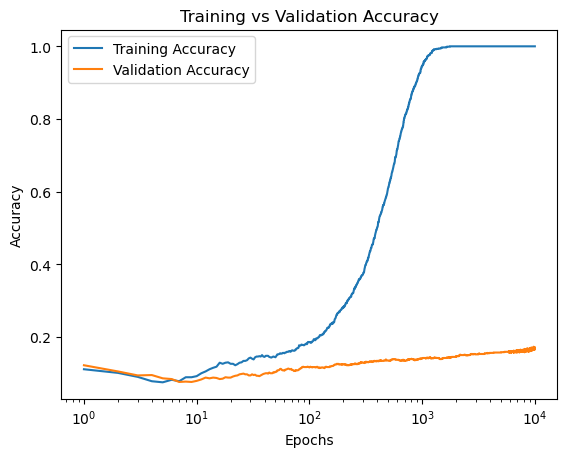

Epoch [20000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.2370, Weight Norm: 125.3902:   7%|▋         | 19998/300000 [13:58<3:20:34, 23.27it/s]

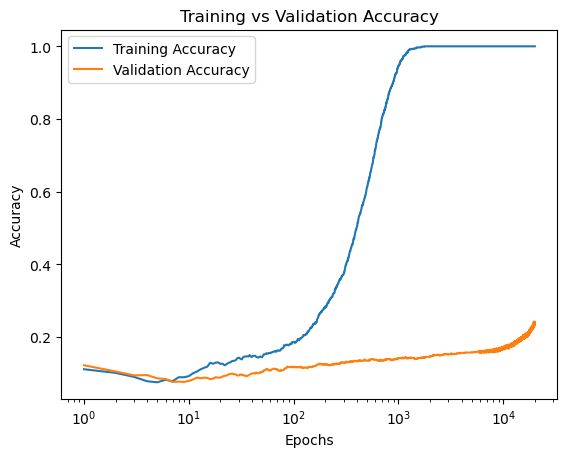

Epoch [30000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.3450, Weight Norm: 112.9108:  10%|▉         | 29998/300000 [21:30<3:23:50, 22.08it/s]

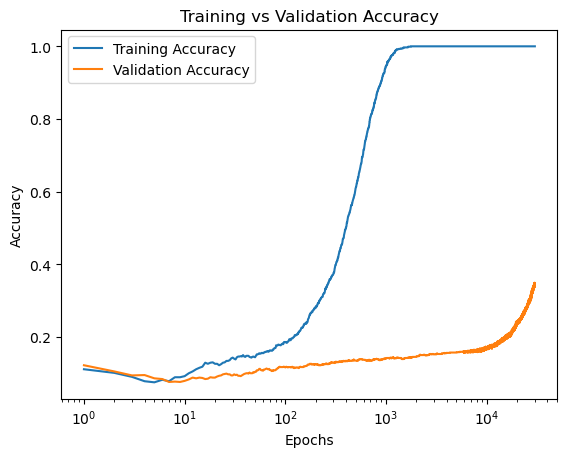

Epoch [40000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4750, Weight Norm: 101.8117:  13%|█▎        | 39997/300000 [29:36<3:31:54, 20.45it/s]

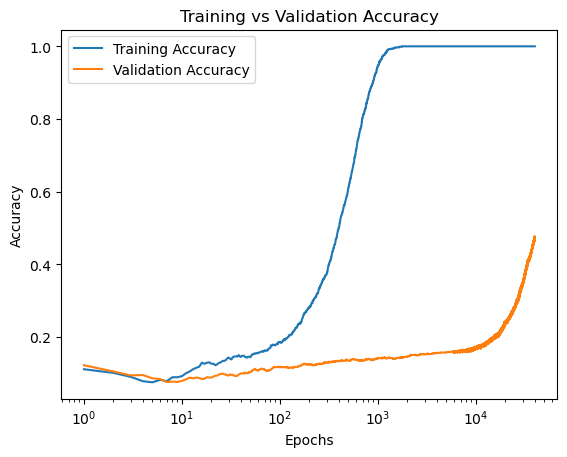

Epoch [50000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5920, Weight Norm: 92.2934:  17%|█▋        | 49998/300000 [37:56<3:25:37, 20.26it/s] 

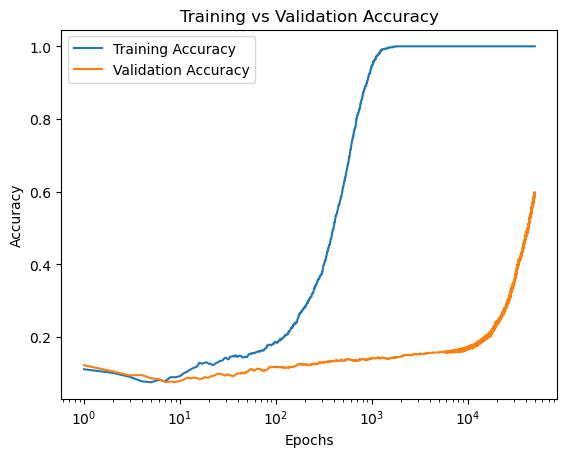

Epoch [60000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.6700, Weight Norm: 84.4514:  20%|█▉        | 59999/300000 [46:24<3:21:01, 19.90it/s]

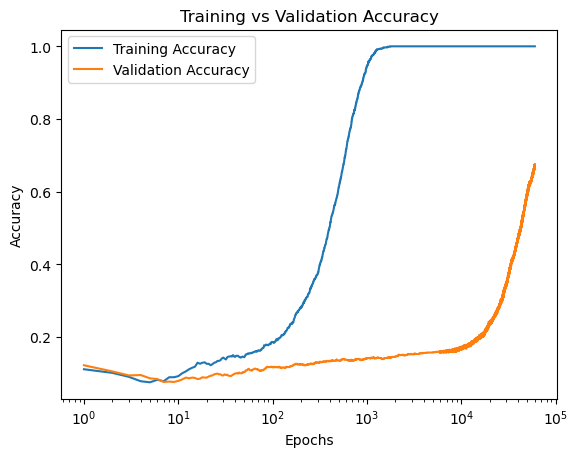

Epoch [70000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.7300, Weight Norm: 78.0632:  23%|██▎       | 69999/300000 [54:54<3:15:52, 19.57it/s]

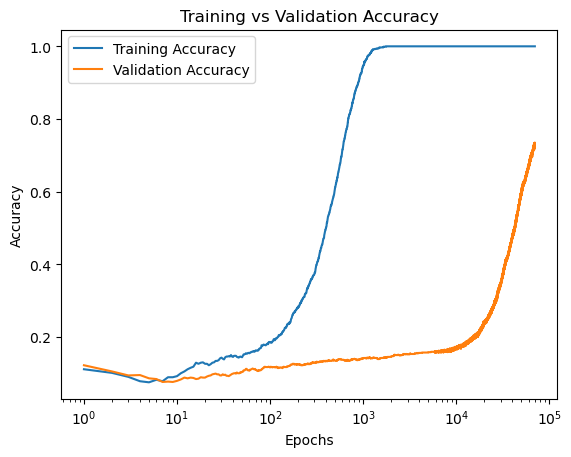

Epoch [80000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.7760, Weight Norm: 72.9903:  27%|██▋       | 79999/300000 [1:03:24<3:04:07, 19.91it/s]

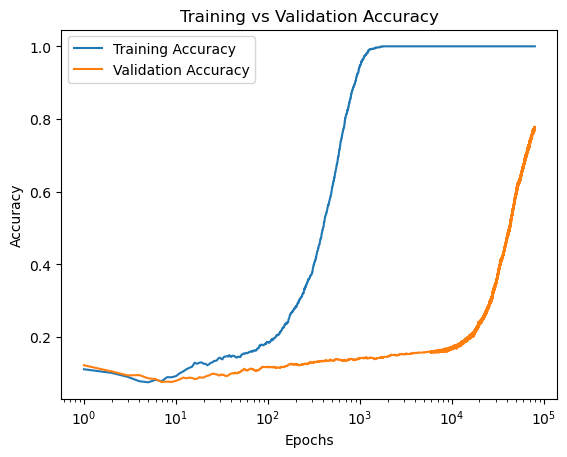

Epoch [90000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8050, Weight Norm: 69.0279:  30%|██▉       | 89998/300000 [1:11:57<2:58:16, 19.63it/s]

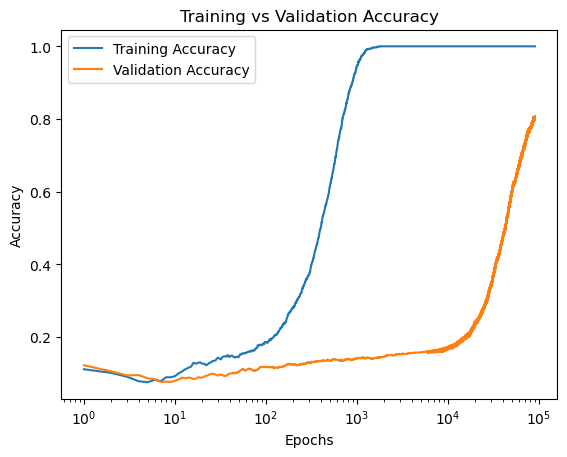

Epoch [100000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8140, Weight Norm: 65.5316:  33%|███▎      | 99998/300000 [1:20:33<2:52:23, 19.34it/s]

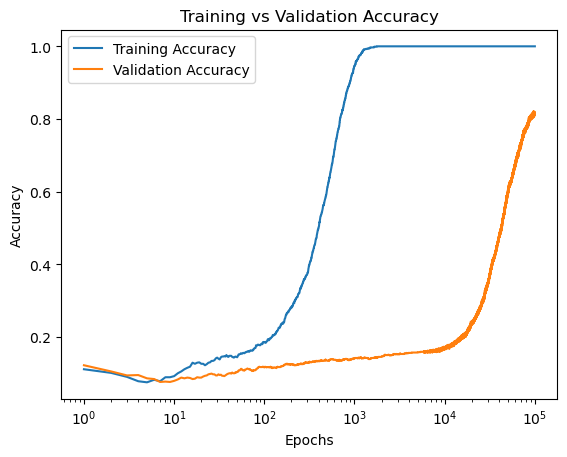

Epoch [110000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8280, Weight Norm: 62.8933:  37%|███▋      | 109999/300000 [1:29:09<2:45:16, 19.16it/s]

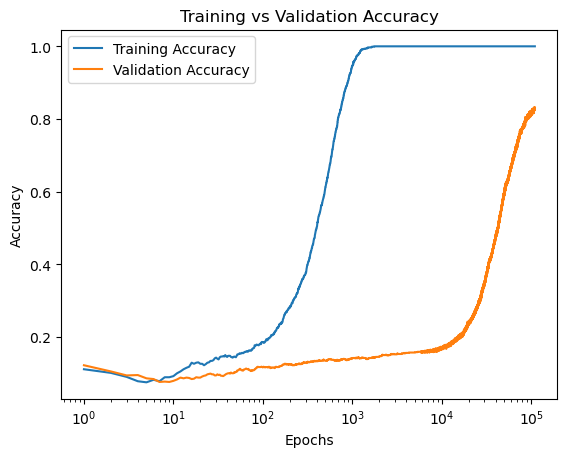

Epoch [120000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8390, Weight Norm: 60.8339:  40%|███▉      | 119998/300000 [1:37:44<2:32:28, 19.68it/s]

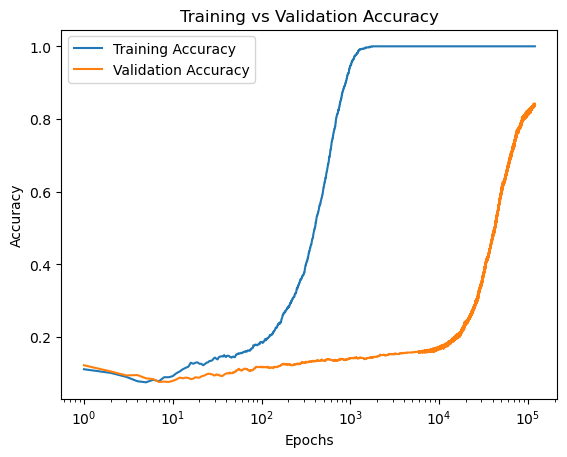

Epoch [130000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8500, Weight Norm: 59.0342:  43%|████▎     | 129999/300000 [1:46:17<2:22:03, 19.94it/s]

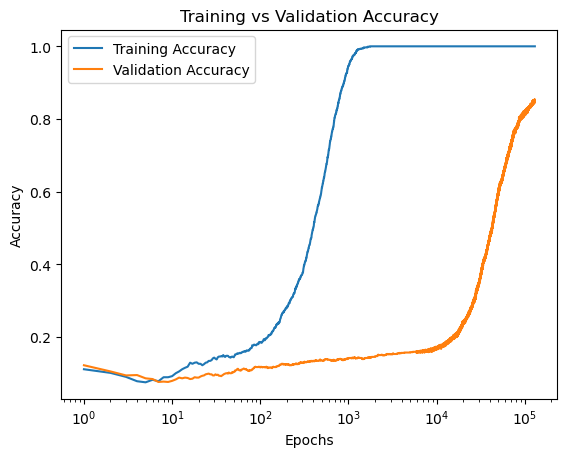

Epoch [140000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8520, Weight Norm: 57.4474:  47%|████▋     | 139998/300000 [1:54:52<2:21:41, 18.82it/s]

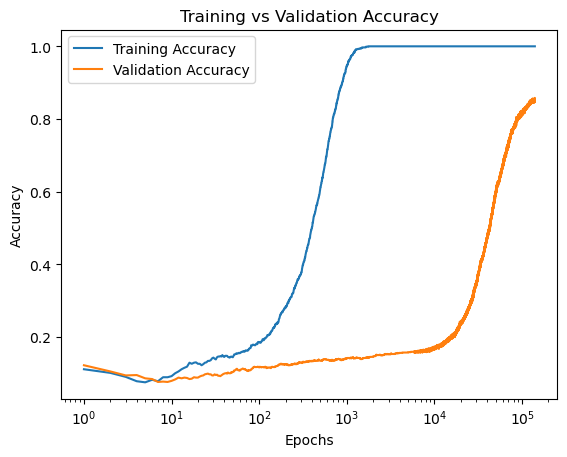

Epoch [150000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8570, Weight Norm: 56.5324:  50%|████▉     | 149999/300000 [2:03:32<2:07:43, 19.57it/s]

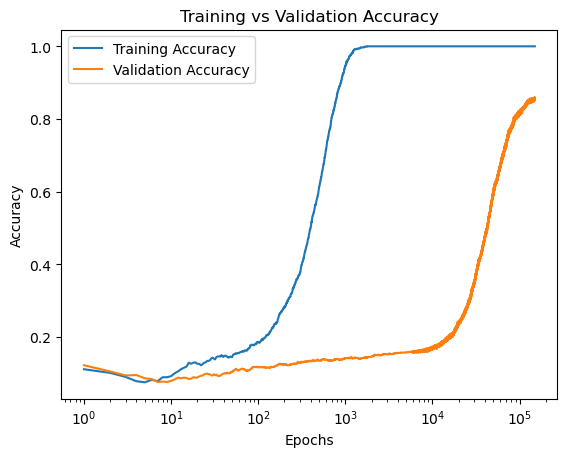

Epoch [160000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8620, Weight Norm: 55.7822:  53%|█████▎    | 159999/300000 [2:12:19<1:58:49, 19.64it/s]

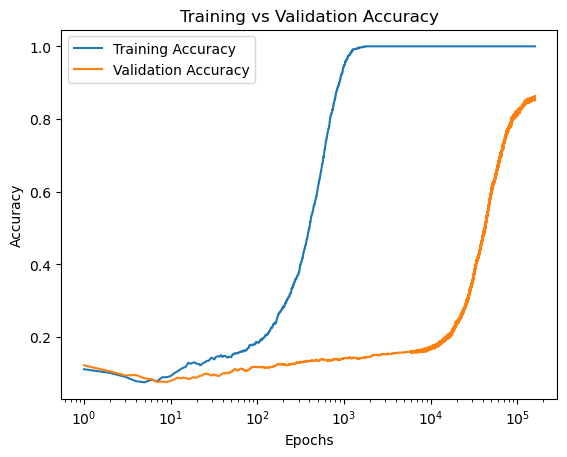

Epoch [170000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8590, Weight Norm: 54.1250:  57%|█████▋    | 169999/300000 [2:20:58<1:51:55, 19.36it/s]

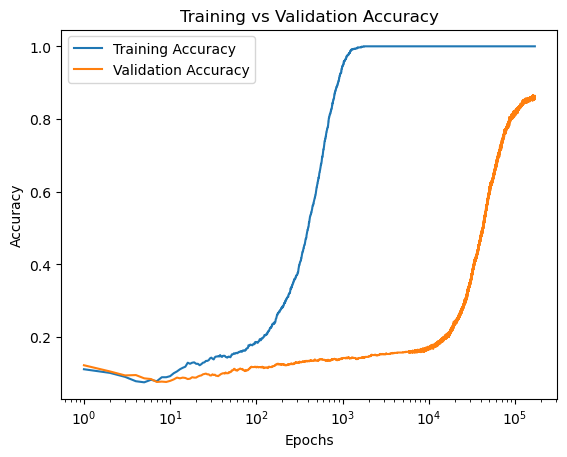

Epoch [180000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8640, Weight Norm: 53.2813:  60%|█████▉    | 179998/300000 [2:29:23<1:38:30, 20.30it/s]

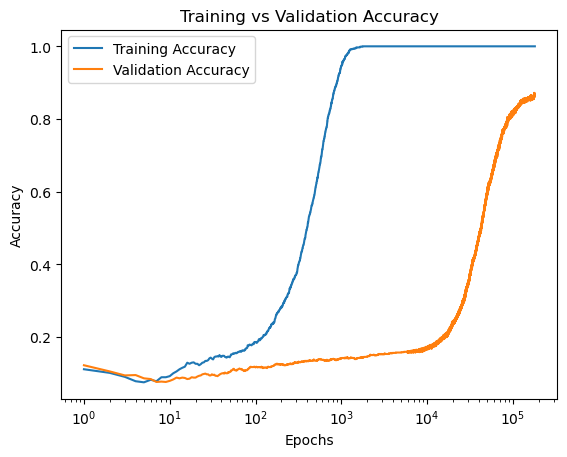

Epoch [190000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8720, Weight Norm: 52.4709:  63%|██████▎   | 189999/300000 [2:37:49<1:43:00, 17.80it/s]

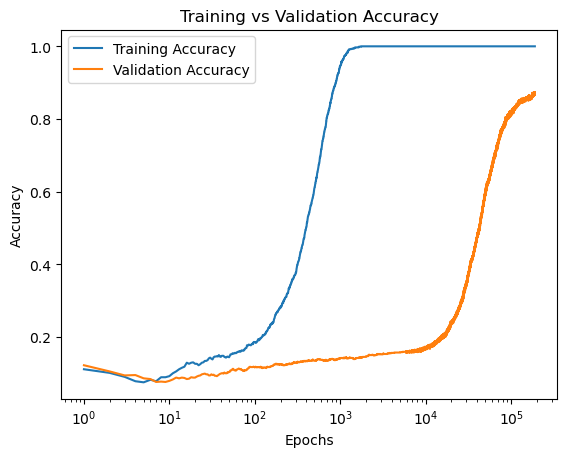

Epoch [200000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8720, Weight Norm: 51.6976:  67%|██████▋   | 199997/300000 [2:46:16<1:29:49, 18.55it/s]

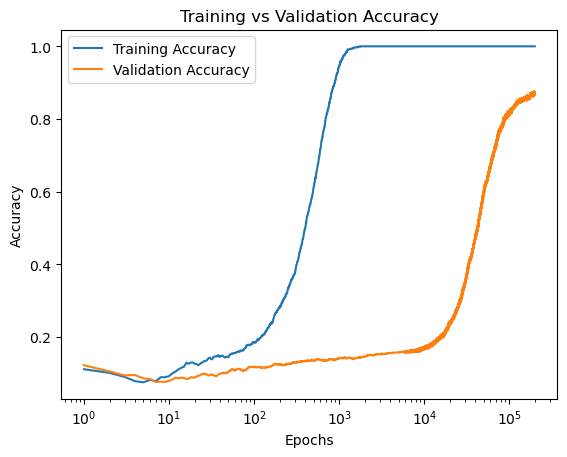

Epoch [210000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8720, Weight Norm: 51.3066:  70%|██████▉   | 209998/300000 [2:54:40<1:15:05, 19.98it/s]

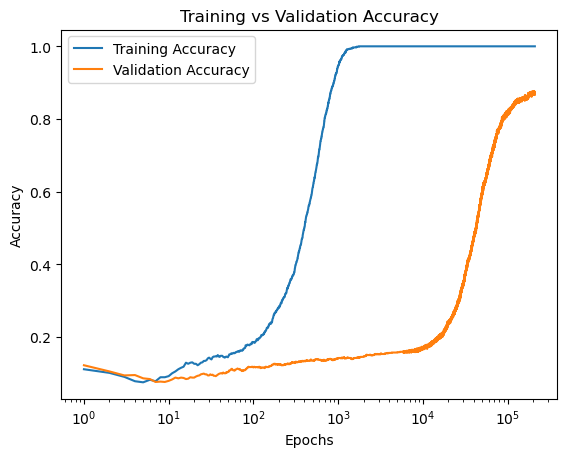

Epoch [220000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8720, Weight Norm: 50.6455:  73%|███████▎  | 219998/300000 [3:03:06<1:06:39, 20.00it/s]

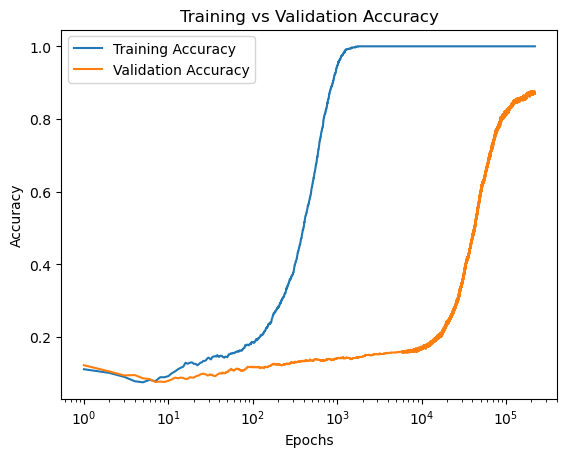

Epoch [230000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8730, Weight Norm: 50.0664:  77%|███████▋  | 229998/300000 [3:11:26<56:26, 20.67it/s]  

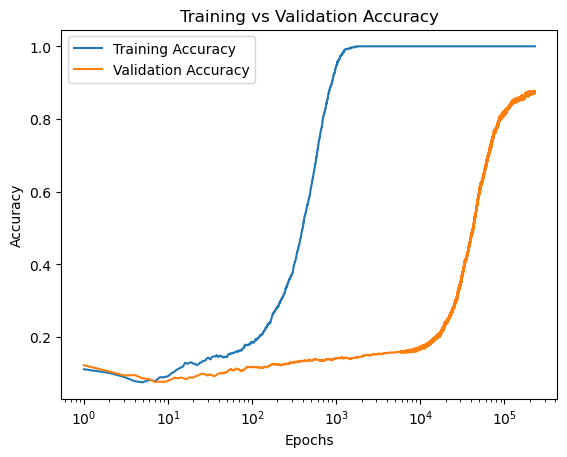

Epoch [240000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8740, Weight Norm: 49.9770:  80%|███████▉  | 239999/300000 [3:19:45<49:40, 20.13it/s]  

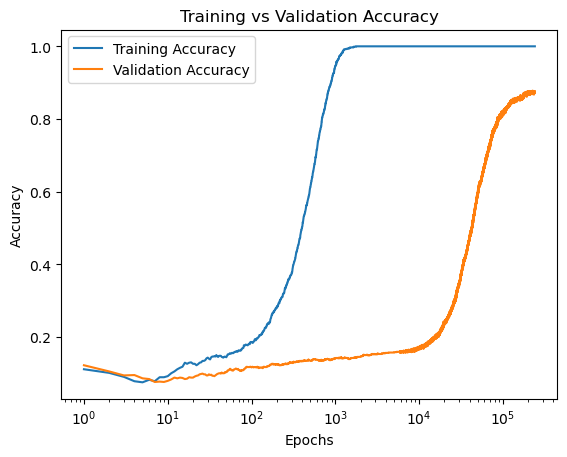

Epoch [250000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8700, Weight Norm: 49.2309:  83%|████████▎ | 249999/300000 [3:28:05<42:38, 19.55it/s]  

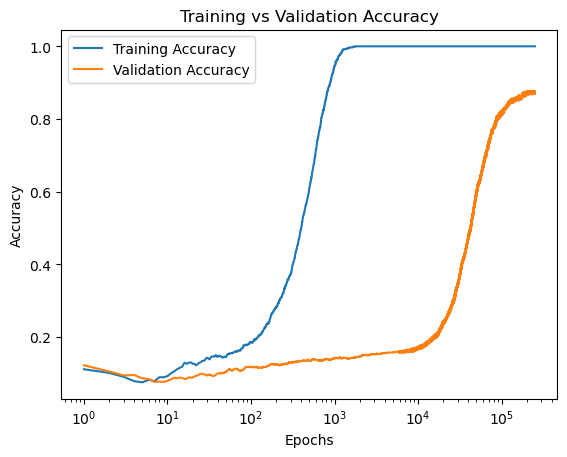

Epoch [260000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8730, Weight Norm: 48.7457:  87%|████████▋ | 259998/300000 [3:36:24<32:41, 20.39it/s]  

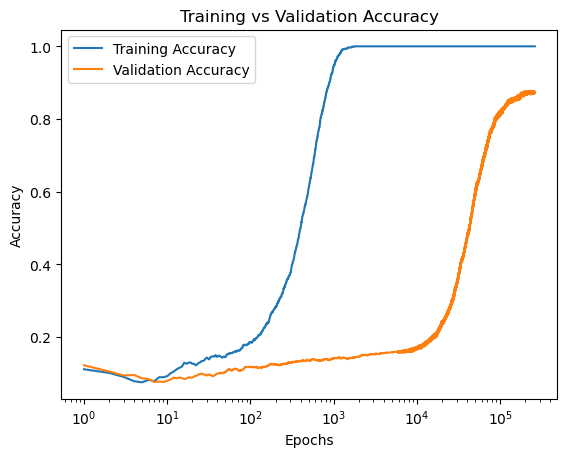

Epoch [270000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8760, Weight Norm: 48.6873:  90%|████████▉ | 269998/300000 [3:44:42<24:28, 20.43it/s]

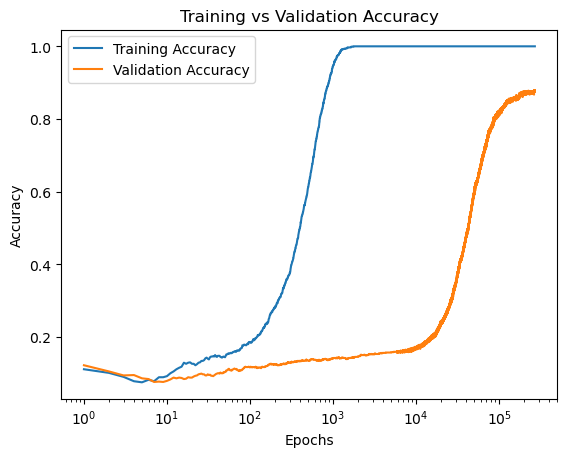

Epoch [280000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8740, Weight Norm: 48.0791:  93%|█████████▎| 279998/300000 [3:53:00<16:45, 19.90it/s]

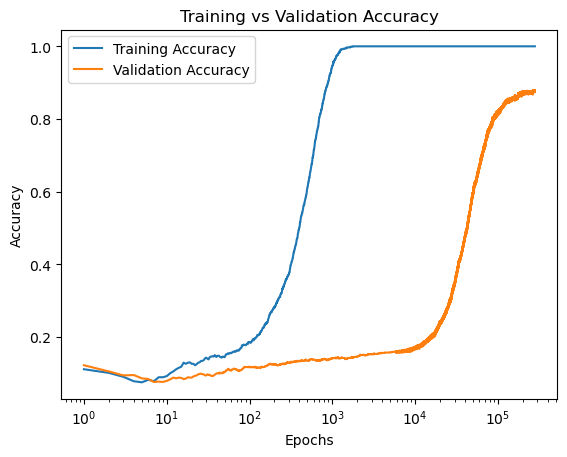

Epoch [290000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8760, Weight Norm: 47.7109:  97%|█████████▋| 289997/300000 [4:14:15<20:53,  7.98it/s]    

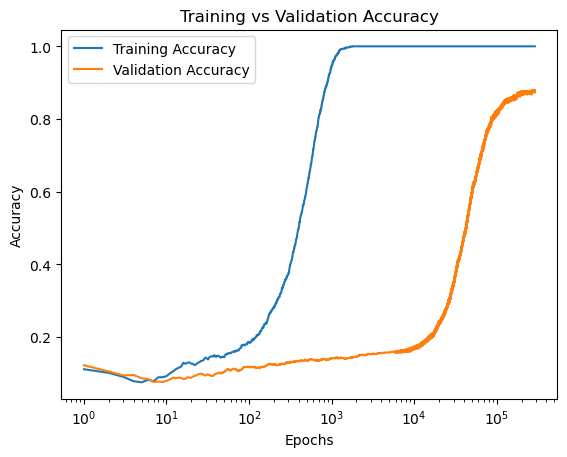

Epoch [300000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8780, Weight Norm: 48.7208: 100%|█████████▉| 299999/300000 [4:37:21<00:00, 23.04it/s]    

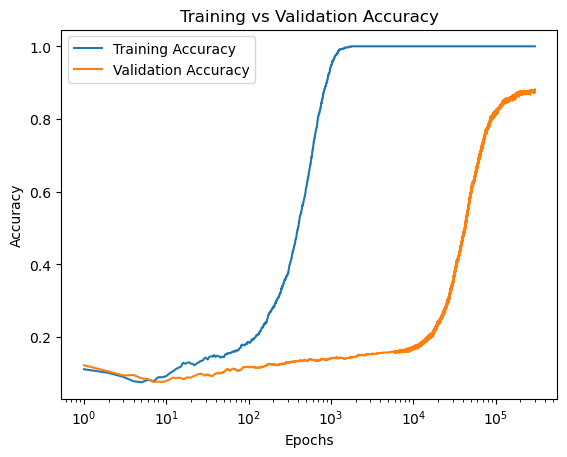

Epoch [300000/300000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.8780, Weight Norm: 48.7208: 100%|██████████| 300000/300000 [4:37:22<00:00, 18.03it/s]


In [10]:
#Training

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

train_acc = []
val_acc = []
train_loss = []
weight_normlist = []

#Loop
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        labels_one_hot = F.one_hot(labels, 10).float()
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate Train Accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)
    
    # Store loss
    train_loss.append(loss.item())
    
    # Calculate Validation Accuracy
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for x, labels in test_loader:
            x = x.to(device)
            labels = labels.to(device)
            y = model(x)
            _, predicted = torch.max(y, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_acc.append(val_accuracy)

    # Calculate Weight Norm
    weight_norm = sum(p.norm().item() for p in model.parameters())
    weight_normlist.append(weight_norm)
    
    # Print progress
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Weight Norm: {weight_norm:.4f}')
    
    # Plot graph every 50,000 epochs
    if (epoch + 1) % 10000 == 0:
        import matplotlib.pyplot as plt
        plt.xscale("log")
        plt.plot(range(1, epoch + 2), train_acc, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()
        plt.show()


In [11]:
#Evaluate
model.eval()
total = 0
correct = 0
one_hots = torch.eye(10, 10)
with torch.no_grad():
        for x, labels in test_loader:
            x = x.to(device)
            labels = labels.to(device)
            y = model(x)
            _, predicted = torch.max(y,1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)


print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 87.80%


Accuracy: 87.80%


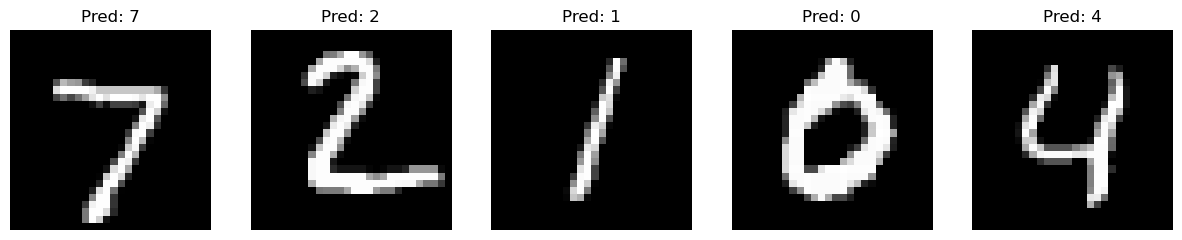

In [12]:
import matplotlib.pyplot as plt

# Function to display images and predictions
def display_predictions(model, testloader, num_images=5):
    model.eval()
    images, labels = next(iter(testloader))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].to("cpu").numpy().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}')
        ax.axis('off')
    plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
one_hots = torch.eye(10, 10)

with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        labels = labels.to(device)
        y = model(x)
        _, predicted = torch.max(y, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f'Accuracy: {100 * accuracy:.2f}%')

# Display example predictions
display_predictions(model, test_loader, num_images=5)


"#Training\n\ncriterion = nn.MSELoss()\noptimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)\n\ntrain_acc = []\nval_acc = []\ntrain_loss = []\nweight_normlist = []\n\n#Loop\nbar = tqdm(range(epochs))\nfor epoch in bar:\n    model.train()\n    running_loss = 0.0\n    correct_train = 0\n    total_train = 0\n    \n    for images, labels in train_loader:\n        optimizer.zero_grad()\n        outputs = model(images)\n        labels_one_hot = F.one_hot(labels, 10).float()\n        loss = criterion(outputs, labels_one_hot)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n\n    #Calculate Train Accuracy\n    _, predicted = torch.max(outputs.data, 1)\n    correct_train += (predicted == labels).sum().item()\n    total_train += labels.size(0)\n    train_accuracy = correct_train / total_train\n    train_acc.append(train_accuracy)\n    #Store loss\n    train_loss.append(loss)\n    #Calculate Validation Accuracy\n    model.eval()\n    tot